# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Is the pipeline functional?
  * Check of output at each stage of pipeline
* simulating 3 isopycnic gradients for both treatment & control  

# Setting variables

In [2]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation_rep3/'
genomeDir = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/bac_genome_n1147/'

bandwidth = 0.8
DBL_scaling = 0.5
subsample_dist = 'lognormal'
subsample_mean = 9.432
subsample_scale = 0.5
subsample_min = 10000
subsample_max = 30000

# Init

In [3]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image
import os
%load_ext rpy2.ipython
%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figureDir):
    os.makedirs(figureDir)    
    
%cd $workDir    

/home/nick/notebook/SIPSim/dev/bac_genome1147/validation_rep3


In [6]:
# Determining min/max BD that 
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_range_BD = min_GC/100.0 * 0.098 + 1.66    
max_range_BD = max_GC/100.0 * 0.098 + 1.66    

max_range_BD = max_range_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_range_BD)
print 'Max BD: {}'.format(max_range_BD)

Min BD: 1.67323
Max BD: 1.7744


# Simulating fragments

In [6]:
# estimated coverage
mean_frag_size = 9000.0
mean_amp_len = 300.0
n_frags = 10000

coverage = round(n_frags * mean_amp_len / mean_frag_size, 1)
msg = 'Average coverage from simulating {} fragments: {}X'
print msg.format(n_frags, coverage)

Average coverage from simulating 10000 fragments: 333.3X


In [7]:
!SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

In [8]:
!printf "Number of taxa with >=1 amplicon: "
!grep "Number of amplicons: " ampFrags.log | \
    perl -ne "s/^.+ +//; print unless /^0$/" | wc -l

Number of taxa with >=1 amplicon: 1102


## Number of amplicons per taxon

In [9]:
!grep "Number of amplicons: " ampFrags.log | \
    perl -pe 's/.+ +//' | hist


 338|    o       
 320|    o       
 303|    o       
 285|    o       
 268|    o       
 250|    o       
 232|   oo       
 215|   oo       
 197|   oo       
 180|   oo       
 162|   oo o     
 144|   oo o     
 127|  ooo o     
 109|  ooo o     
  92|  ooooo     
  74|  ooooo     
  56|  ooooo     
  39| oooooo o   
  21| oooooooo   
   4| ooooooooooo
     -----------

------------------------------
|          Summary           |
------------------------------
|     observations: 1147     |
|    min value: 0.000000     |
|      mean : 3.823888       |
|    max value: 15.000000    |
------------------------------


# Converting fragments to kde object

In [10]:
!SIPSim fragment_KDE \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Checking ampfrag info

In [11]:
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt

Loading KDEs...


In [12]:
%%R 
# loading
df = read.delim('ampFrags_kde_info.txt', sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

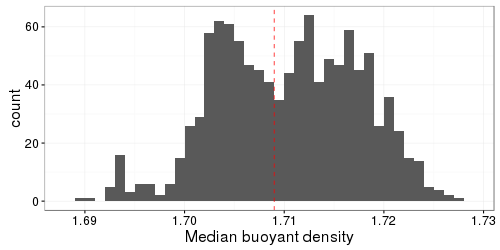

In [13]:
%%R -w 500 -h 250
# plotting
p.amp = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.amp

# Making an incorp config file

* 10% of taxa with 100% atom excess 13C

In [14]:
!SIPSim incorpConfigExample \
    --percTaxa 10 \
    --percIncorpUnif 100 \
    --n_reps 3 \
    > PT10_PI100.config
    
# checking output
!cat PT10_PI100.config


[1]
    # baseline: no incorporation
    treatment = control
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            
            [[[[interPopDist 1]]]]
                distribution = uniform
                start = 0
                end = 0
        
        [[[end]]]
            
            [[[[interPopDist 1]]]]
                distribution = uniform
                start = 0
                end = 0
[2]
    # 'treatment' community: possible incorporation
    treatment = labeled
    max_perc_taxa_incorp = 10
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            [[[[interPopDist 1]]]]
                start = 100
                distribution = uniform
                end = 100
        
        [[[end]]]
            [[[[interPopDist 1]]]]
                start = 100
                distribution = uniform
                end = 100
    

[3]
    # baseline: no incorporation
    treatment = control
 

# Selecting incorporator taxa

* This is to make the gradient replicates consistent (qSIP finds mean among replicates)

In [15]:
!SIPSim KDE_selectTaxa \
    -f 0.1 \
    ampFrags_kde.pkl \
    > incorporators.txt

Loading KDEs...
Subsampled 114 taxa


# Creating a community file

* 2 communities
  * control vs treatment

In [16]:
!SIPSim communities \
    --config PT10_PI100.config \
    $genomeDir/genome_index.txt \
    > comm.txt

## Plotting community rank abundances

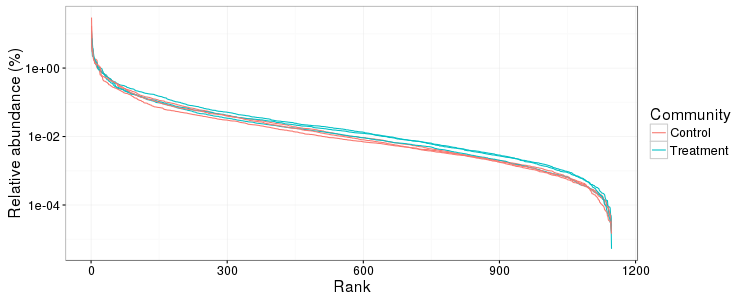

In [17]:
%%R -w 750 -h 300


tbl = read.delim('comm.txt', sep='\t') %>%
    mutate(library = library %>% as.character %>% as.numeric,
           condition = ifelse(library %% 2 == 0, 'Control', 'Treatment'))

ggplot(tbl, aes(rank, rel_abund_perc, color=condition, group=library)) +
    geom_line() +
    scale_y_log10() +
    scale_color_discrete('Community') +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating gradient fractions

In [18]:
!SIPSim gradient_fractions \
    --BD_min $min_range_BD \
    --BD_max $max_range_BD \
    comm.txt \
    > fracs.txt    

## Plotting fractions

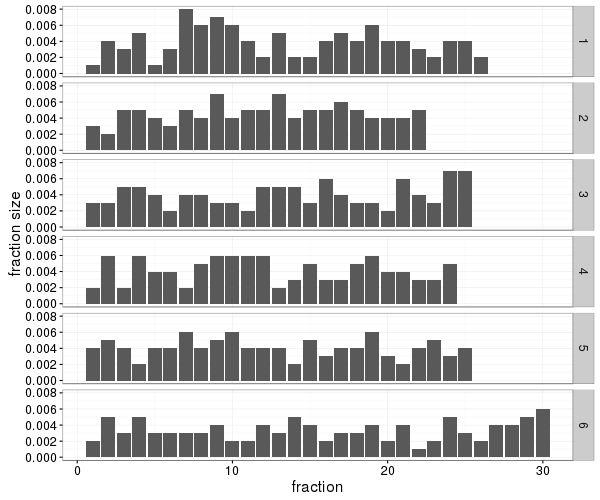

In [19]:
%%R -w 600 -h 500

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_bar(stat='identity') +
    facet_grid(library ~ .) +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

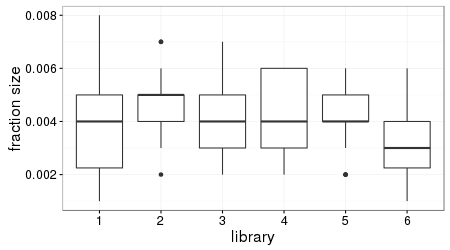

In [20]:
%%R -w 450 -h 250
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Adding diffusion

In [95]:
!SIPSim diffusion \
    --bw $bandwidth \
    --np 20 \
    ampFrags_kde.pkl \
    > ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif.log

# Adding DBL 'smearing'

* DBL = diffusive boundary layer

In [96]:
!SIPSim DBL \
    --comm comm.txt \
    --commx $DBL_scaling \
    --np 20 \
    -o ampFrags_kde_dif_DBL.pkl \
    ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif_DBL.log
    
# checking output    
!tail -n 5 ampFrags_kde_dif_DBL.log

Processing: Dictyoglomus_thermophilum_H-6-12
Processing: Oscillatoria_acuminata_PCC_6304
Processing: Ruminococcus_albus_7_DSM_20455
Processing: Acidimicrobium_ferrooxidans_DSM_10331
Processing: Mycobacterium_africanum_GM041182


## Comparing DBL+diffusion to diffusion

In [97]:
# none
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt
    
# diffusion
!SIPSim KDE_info \
    -s ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_info.txt
    
# diffusion + DBL    
!SIPSim KDE_info \
    -s ampFrags_kde_dif_DBL.pkl \
    > ampFrags_kde_dif_DBL_info.txt

Loading KDEs...
Loading KDEs...
Loading KDEs...


In [98]:
%%R 

inFile = 'ampFrags_kde_info.txt'
df.raw = read.delim(inFile, sep='\t') %>%
    filter(KDE_ID == 1)
df.raw$stage = 'raw'

inFile = 'ampFrags_kde_dif_info.txt'
df.dif = read.delim(inFile, sep='\t')
df.dif$stage = 'diffusion'

inFile = 'ampFrags_kde_dif_DBL_info.txt'
df.DBL = read.delim(inFile, sep='\t')
df.DBL$stage = 'diffusion +\nDBL'

df = rbind(df.raw, df.dif, df.DBL)
df.dif = ''
df.DBL = ''
df %>% head(n=3)

  lib_ID                      taxon_ID KDE_ID      min percentile_5
1      1 Tropheryma_whipplei_str_Twist      1 1.706481     1.707310
2      1 Sorangium_cellulosum_So0157-2      1 1.714261     1.717002
3      1       Bacillus_subtilis_QB928      1 1.701152     1.703675
  percentile_25     mean   median percentile_75 percentile_95      max
1      1.708239 1.709704 1.709822      1.710689      1.712679 1.718498
2      1.720337 1.723415 1.723941      1.726853      1.727987 1.730335
3      1.706275 1.708281 1.708309      1.711007      1.711719 1.714642
        stdev stage
1 0.001641264   raw
2 0.003676067   raw
3 0.002696746   raw


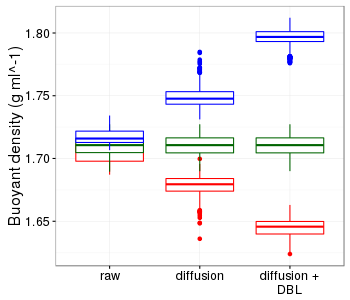

In [99]:
%%R -w 350 -h 300

df$stage = factor(df$stage, levels=c('raw', 'diffusion', 'diffusion +\nDBL'))

ggplot(df, aes(stage)) +
    geom_boxplot(aes(y=min), color='red') +
    geom_boxplot(aes(y=median), color='darkgreen') +
    geom_boxplot(aes(y=max), color='blue') +
    labs(y = 'Buoyant density (g ml^-1)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

# Adding isotope incorporation to BD distribution

In [126]:
!SIPSim isotope_incorp \
    --comm comm.txt \
    --shift ampFrags_BD-shift.txt \
    --taxa incorporators.txt \
    --np 20 \
    -o ampFrags_kde_dif_DBL_incorp.pkl \
    ampFrags_kde_dif_DBL.pkl \
    PT10_PI100.config \
    2> ampFrags_kde_dif_DBL_incorp.log
    
# checking log
!tail -n 5 ampFrags_kde_dif_DBL_incorp.log

Processing: Chlorobium_phaeobacteroides_BS1
Processing: Dyadobacter_fermentans_DSM_18053
Processing: Bifidobacterium_scardovii_JCM_12489_DSM_13734
Processing: Starkeya_novella_DSM_506
File written: ampFrags_BD-shift.txt


# Plotting stats on BD shift from isotope incorporation

In [128]:
%%R
inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character)

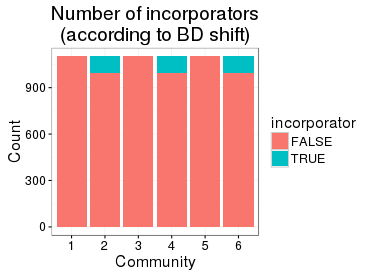

In [129]:
%%R -h 275 -w 375

inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character %>% as.numeric)

df.s = df %>% 
    mutate(incorporator = ifelse(min > 0.001, TRUE, FALSE),
           incorporator = ifelse(is.na(incorporator), 'NA', incorporator),
           condition = ifelse(library %% 2 == 0, 'control', 'treatment')) %>%
    group_by(library, incorporator, condition) %>%
    summarize(n_incorps = n())


# plotting
ggplot(df.s, aes(library %>% as.character, n_incorps, fill=incorporator)) +
    geom_bar(stat='identity') +
    labs(x='Community', y = 'Count', title='Number of incorporators\n(according to BD shift)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Simulating an OTU table

In [130]:
!SIPSim OTU_table \
    --abs 1e9 \
    --np 20 \
    ampFrags_kde_dif_DBL_incorp.pkl \
    comm.txt \
    fracs.txt \
    > OTU_n2_abs1e9.txt \
    2> OTU_n2_abs1e9.log 
    
# checking log
!tail -n 5 OTU_n2_abs1e9.log 

   taxon abs-abundance:  12631154
  Processing taxon: "Colwellia_psychrerythraea_34H"
   taxon abs-abundance:  12440391
  Processing taxon: "Hyphomonas_neptunium_ATCC_15444"
   taxon abs-abundance:  12423081


## Plotting taxon abundances

In [131]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp50 = 0.5 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

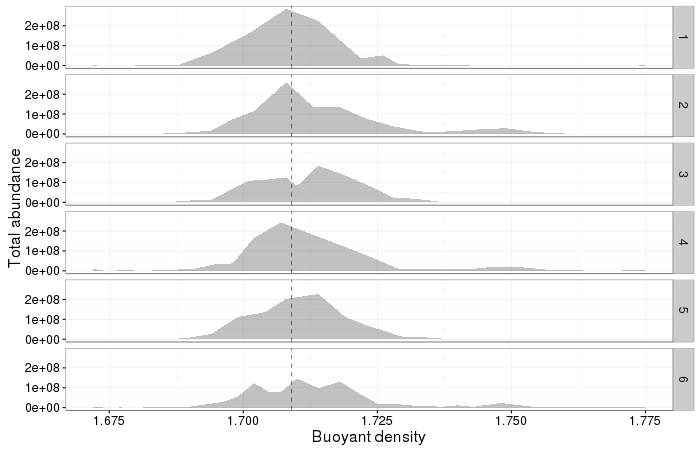

In [132]:
%%R -w 700 -h 450
# plotting absolute abundances

# loading file
df = read.delim('OTU_n2_abs1e9.txt', sep='\t') 

df.s = df %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count)) 

## plot
p = ggplot(df.s, aes(BD_mid, total_count)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Total abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

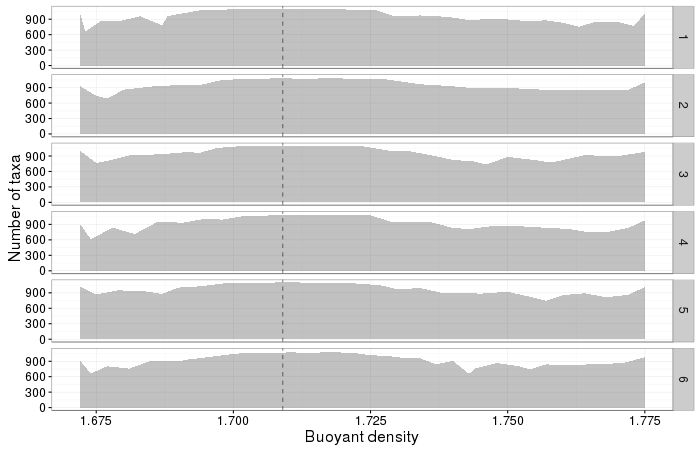

In [133]:
%%R -w 700 -h 450
# plotting number of taxa at each BD

df.nt = df %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.nt, aes(BD_mid, n_taxa)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

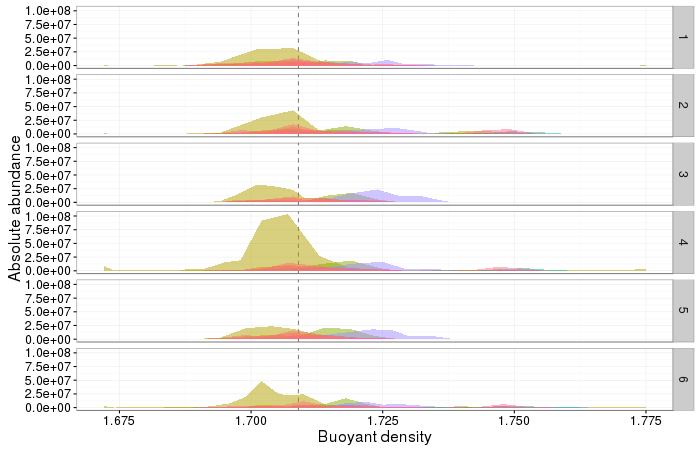

In [134]:
%%R -w 700 -h 450
# plotting relative abundances

## plot
p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Absolute abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

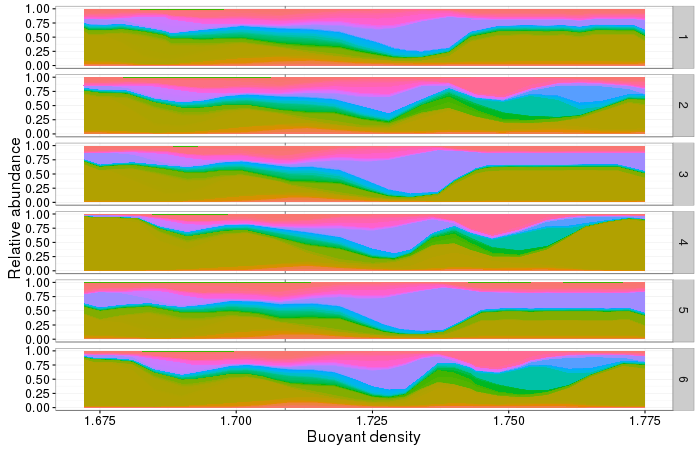

In [135]:
%%R -w 700 -h 450
p + 
    geom_area(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance')

# Simulating PCR bias

In [136]:
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    --debug \
    > OTU_n2_abs1e9_PCR.txt

## Plotting change in relative abundances

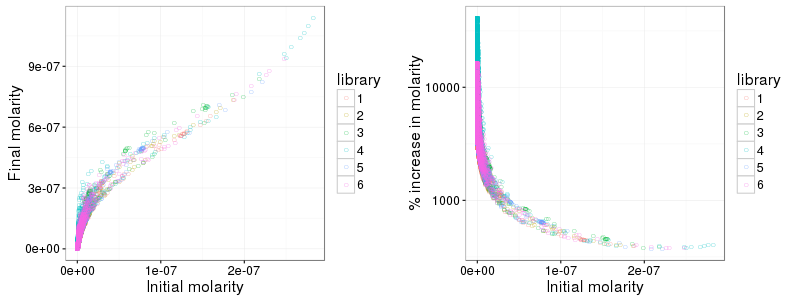

In [137]:
%%R -w 800 -h 300
# loading file
F = 'OTU_n2_abs1e9_PCR.txt'
df.SIM = read.delim(F, sep='\t') %>%
    mutate(molarity_increase = final_molarity / init_molarity * 100,
           library = library %>% as.character)

p1 = ggplot(df.SIM, aes(init_molarity, final_molarity, color=library)) +
    geom_point(shape='O', alpha=0.5) +
    labs(x='Initial molarity', y='Final molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(df.SIM, aes(init_molarity, molarity_increase, color=library)) +
    geom_point(shape='O', alpha=0.5) +
    scale_y_log10() +
    labs(x='Initial molarity', y='% increase in molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=2)

In [138]:
# PCR w/out --debug (no extra output)
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    > OTU_n2_abs1e9_PCR.txt

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [139]:
!SIPSim OTU_subsample \
    --dist $subsample_dist \
    --dist_params mean:$subsample_mean,sigma:$subsample_scale \
    --min_size $subsample_min \
    --max_size $subsample_max \
    OTU_n2_abs1e9_PCR.txt \
    > OTU_n2_abs1e9_PCR_subNorm.txt

### Plotting seq count distribution

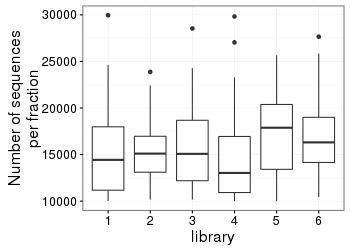

In [140]:
%%R -w 350 -h 250

df = read.csv('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

df.s = df %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(df.s, aes(library, total_count)) +
    geom_boxplot() +
    labs(y='Number of sequences\nper fraction') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting abundance distributions 

In [141]:
%%R 

# loading file
df.abs = read.delim('OTU_n2_abs1e9.txt', sep='\t')
df.sub = read.delim('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

#lib.reval = c('1' = 'control',
#              '2' = 'treatment',
#              '3' = 'control',
#              '4' = 'treatment',
#              '5' = 'control',
#              '6' = 'treatment')

#df.abs = mutate(df.abs, library = plyr::revalue(as.character(library), lib.reval))
#df.sub = mutate(df.sub, library = plyr::revalue(as.character(library), lib.reval))

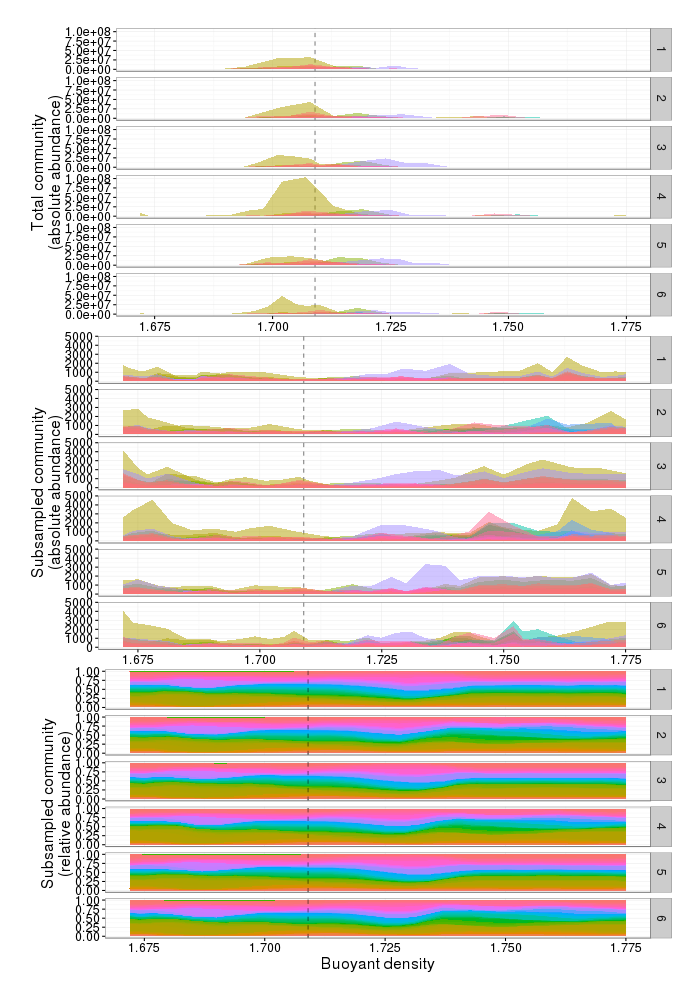

In [142]:
%%R -w 700 -h 1000
# plotting absolute abundances
## plot
p = ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Total community\n(absolute abundance)')

# plotting absolute abundances of subsampled
## plot
p = ggplot(df.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Subsampled community\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

# plotting relative abundances of subsampled
p3 = p + geom_area(stat='identity', position='fill') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(y='Subsampled community\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

# combining plots
grid.arrange(p1, p2, p3, ncol=1)

# Making a wide OTU table

In [143]:
!SIPSim OTU_wideLong -w \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_w.txt

# Making metadata (phyloseq: sample_data)

In [144]:
!SIPSim OTU_sampleData \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_meta.txt

# Community analysis

## Phyloseq

In [145]:
# making phyloseq object from OTU table
!SIPSimR phyloseq_make \
    OTU_n2_abs1e9_PCR_subNorm_w.txt \
    -s OTU_n2_abs1e9_PCR_subNorm_meta.txt \
    > OTU_n2_abs1e9_PCR_subNorm.physeq

## making ordination
!SIPSimR phyloseq_ordination \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf    

## filtering phyloseq object to just taxa/samples of interest (eg., BD-min/max)
!SIPSimR phyloseq_edit \
    --BD_min 1.71 \
    --BD_max 1.75 \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    > OTU_n2_abs1e9_PCR_subNorm_filt.physeq

## making ordination
!SIPSimR phyloseq_ordination \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf
    
# making png figures
!convert OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png
!convert OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png    

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.09430264 
Run 1 stress 0.09430265 
... procrustes: rmse 9.104237e-06  max resid 6.060006e-05 
*** Solution reached
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 6 rows containing missing values (geom_point). 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 6 rows containing missing values (geom_point). 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
pre-filter: number of samples:164
pre-filter: number of taxa:1147
post-filter: number of samples:6

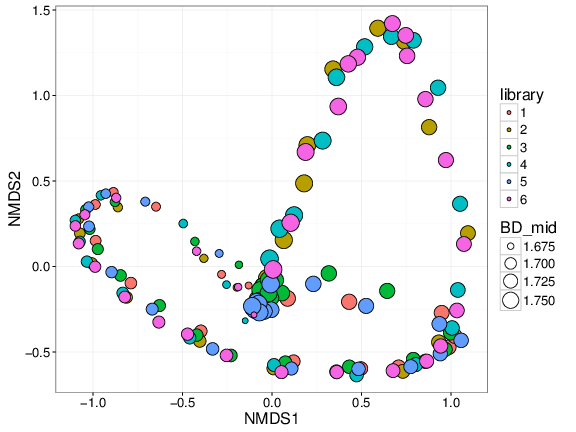

In [146]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png') 

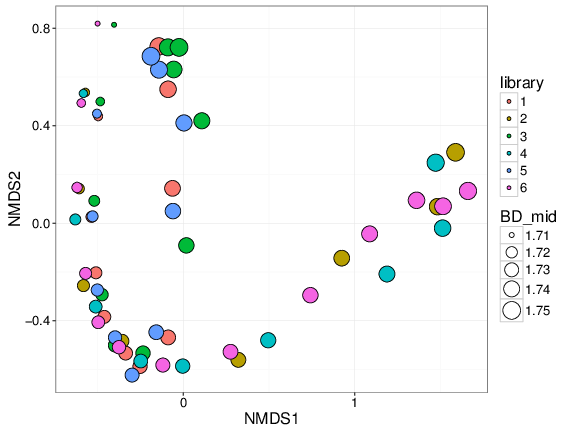

In [147]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png')

## DESeq2

In [81]:
## DESeq2
!SIPSimR phyloseq_DESeq2 \
    --log2 0.25 \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    --occur_all 0.25 \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    > OTU_n2_abs1e9_PCR_subNorm_DS2.txt
    
## Confusion matrix
!SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj 0.1 \
    ampFrags_BD-shift.txt \
    OTU_n2_abs1e9_PCR_subNorm_DS2.txt

Warning message:
replacing previous import ‘S4Vectors::Position’ by ‘ggplot2::Position’ when loading ‘DESeq2’ 
# occurance cutoff: 0.25
 pre-filter: number of taxa: 753
 post-filter: number of taxa: 627
# "heavy" BD window: 1.71-1.75
 pre-filter: number of samples: 61
 post-filter: number of samples: 61
# occurance cutoff: 0
 pre-filter: number of taxa: 627
 post-filter: number of taxa: 627
# DESeq2 run
converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
# Number of rejected hypotheses: 63

# A file of all DESeq2 run results was written to: DESeq2_all_runs.txt

#- Greatest number of rejected hypotheses for each BD window -#
heavy_BD_min	heavy_BD_max	max_n_rej_hypo
1.71	1.75	63

# Global adjustment of p-values for all BW windows with "best" occurance cutoff

#- Number of rejected hypotheses for each BD window (post global p-value adjustmen

  library         variables    values
1       2 Balanced Accuracy 0.8987342
2       4 Balanced Accuracy 0.8987342
3       6 Balanced Accuracy 0.8987342


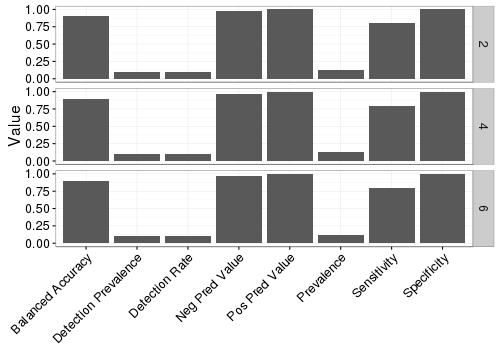

In [82]:
%%R -w 500 -h 350

byClass = read.delim('DESeq2-cMtx_byClass.txt', sep='\t') 

byClass %>% filter(variables=='Balanced Accuracy') %>% print

ggplot(byClass, aes(variables, values)) +
    geom_bar(stat='identity') +
    labs(y='Value') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

## Checking results of confusion matrix

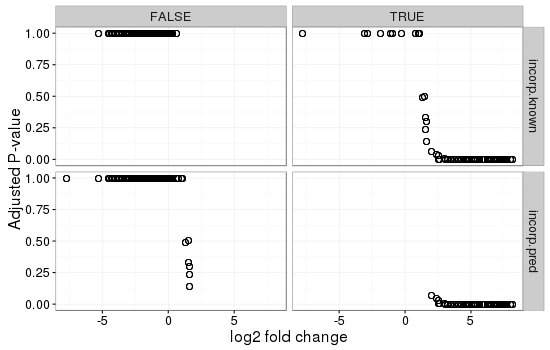

In [69]:
%%R -w 550 -h 350

df_cMtx = read.delim('DESeq2-cMtx_data.txt', sep='\t') %>%
    gather(clsfy, clsfy_value, incorp.pred, incorp.known) %>%
    filter(! is.na(clsfy_value))


ggplot(df_cMtx, aes(log2FoldChange, padj)) +
    geom_point(size=3, shape='O') +
    facet_grid(clsfy ~ clsfy_value) +
    labs(x='log2 fold change', y='Adjusted P-value') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [70]:
%%R -w 300 -h 300
# checking correspondence of padj & padj.BH
# ggplot(df_cMtx, aes(padj, padj.BH)) +
#     geom_point(shape='O', size=2) +
#     theme_bw() +
#     theme(
#         text = element_text(size=16)
#     )

NULL


#### Notes

* It appears the specificity is really 100%
* The sensitivity is still a bit weak though

## Plotting results of DESeq2

In [71]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [72]:
%%R 

df = read.delim('DESeq2-cMtx_data.txt', sep='\t')

df = df %>%
    filter(! is.na(log2FoldChange), library %in% c(2,4,6)) %>%
    mutate(taxon = reorder(taxon, -log2FoldChange),
           cls = mapply(clsfy, incorp.pred, incorp.known))

df %>% head(n=3)

  library                                taxon min q25 mean median q75 max
1       2 Acetobacter_pasteurianus_IFO_3283-03   0   0    0      0   0   0
2       2    Acetohalobium_arabaticum_DSM_5501   0   0    0      0   0   0
3       2       Achromobacter_xylosoxidans_C54   0   0    0      0   0   0
  baseMean log2FoldChange     lfcSE stat    pvalue padj occur_all occur_heavy
1 2.955724     -0.5228025 0.6259375    0 0.8915163    1      0.25           0
2 0.293216     -0.4770202 0.8579307    0 0.8016171    1      0.25           0
3 1.495263     -0.3871322 0.4472277    0 0.9228673    1      0.25           0
  heavy_BD_min heavy_BD_max incorp.known incorp.pred           cls
1         1.71         1.75        FALSE       FALSE True negative
2         1.71         1.75        FALSE       FALSE True negative
3         1.71         1.75        FALSE       FALSE True negative


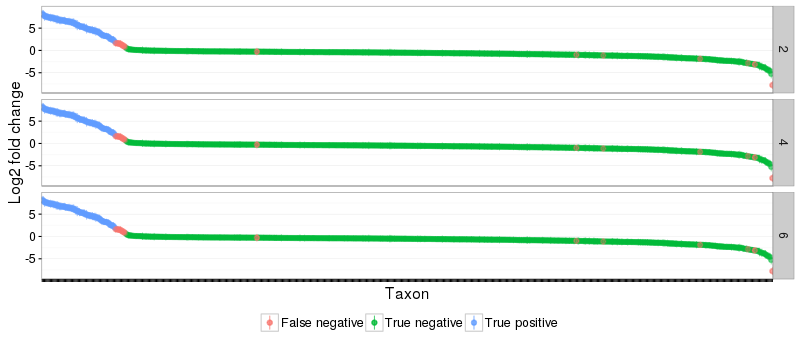

In [73]:
%%R -w 800 -h 350

df.TN = df %>% filter(cls == 'True negative')
df.TP = df %>% filter(cls == 'True positive')
df.FP = df %>% filter(cls == 'False negative')

ggplot(df, aes(taxon, log2FoldChange, color=cls, 
                  ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.4, alpha=0.5) +
    geom_pointrange(data=df.TP, size=0.4, alpha=0.3) +
    geom_pointrange(data=df.FP, size=0.4, alpha=0.3) +
    labs(x = 'Taxon', y = 'Log2 fold change') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),        
        legend.title=element_blank(),
        axis.text.x = element_blank(),
        legend.position = 'bottom'
        )

# qSIP

In [10]:
!SIPSim qSIP \
    OTU_n2_abs1e9.txt \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_qSIP.txt

Loading OTU tables...
Creating qPCR values...
Calculating proportional absolute abundances...


In [13]:
# making an experimental design file for qSIP
import itertools
x = range(1,7)
y = ['control', 'treatment']

expDesignFile = os.path.join(workDir, 'qSIP_exp_design.txt')
with open(expDesignFile, 'wb') as outFH:
    for i,z in itertools.izip(x,itertools.cycle(y)):
        line = '\t'.join([str(i),z])
        outFH.write(line + '\n')

!head $expDesignFile   

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment


In [ ]:
!SIPSim qSIP_atomExcess \
    --np 10 \
    OTU_n2_abs1e9_PCR_subNorm_qSIP.txt \
    qSIP_exp_design.txt \
    > OTU_n2_abs1e9_PCR_subNorm_qSIP_atom.txt  

Loading files...
Calculating density shifts (Z)...
Calculating atom fraction excess (A)...
Calculating bootstrap CIs...
Bootstrap CI (n=1000), processing taxon: Acaryochloris_marina_MBIC11017
Bootstrap CI (n=1000), processing taxon: Actinosynnema_mirum_DSM_43827
Bootstrap CI (n=1000), processing taxon: Alteromonas_mediterranea_U7
WARNING! "Acaryochloris_marina_MBIC11017" --> NAs in bootstrap values. CI values set to nan. This is probably due to a very low abundance in >=1 library.
Bootstrap CI (n=1000), processing taxon: Acetobacter_pasteurianus_IFO_3283-03
Bootstrap CI (n=1000), processing taxon: Azotobacter_chroococcum_NCIMB_8003
Bootstrap CI (n=1000), processing taxon: Bacteroides_thetaiotaomicron_VPI-5482
Bootstrap CI (n=1000), processing taxon: Bifidobacterium_longum_subsp_longum_GT15
Bootstrap CI (n=1000), processing taxon: Burkholderia_cepacia_GG4
Bootstrap CI (n=1000), processing taxon: Calothrix_sp_PCC_6303
Bootstrap CI (n=1000), processing taxon: Candidatus_Liberibacter_solan

# Assessing qSIP atom % excess accuracy

* do the qSIP CIs include the actual atom % excess?
* what is the r^2 of qSIP-predicted atom % excess and actual?

In [20]:
%%R 

df_qSIP = read.delim('OTU_n2_abs1e9_PCR_subNorm_qSIP_atom.txt', sep='\t')

df_shift = read.delim('ampFrags_BD-shift.txt', sep='\t') %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median)


df_qSIP %>% head(n=3) %>% print 
print('------------------------')
df_shift %>% head(n=3) %>% print

                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.705915  1.705000 -0.0009146029
2 Acetobacter_pasteurianus_IFO_3283-03 1.710507  1.711784  0.0012772284
3       Acetobacterium_woodii_DSM_1030 1.704486  1.741328  0.0368417799
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7168060   308.0465         317.6636     307.8814          -0.01698227
2  0.7718039   308.0738         317.6635     308.3039           0.02372154
3  0.6996973   308.0380         317.6637     314.6962           0.68402262
  atom_CI_low atom_CI_high
1          NA           NA
2 0.001992285   0.04370359
3 0.623621054   0.74441194
[1] "------------------------"
Source: local data frame [3 x 2]

                                 taxon median_true_BD_shift
                                (fctr)                (dbl)
1       Acaryochloris_marina_MBIC11017                0.000
2       Acetobacterium_woodii_DSM_1030                0.036

In [35]:
%%R
df.j = inner_join(df_qSIP, df_shift, c('taxon' = 'taxon')) %>%
    filter(!is.na(BD_diff)) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.03, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))
df.j %>% head(n=3)

                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.705915  1.705000 -0.0009146029
2 Acetobacter_pasteurianus_IFO_3283-03 1.710507  1.711784  0.0012772284
3       Acetobacterium_woodii_DSM_1030 1.704486  1.741328  0.0368417799
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7168060   308.0465         317.6636     307.8814           0.00000000
2  0.7718039   308.0738         317.6635     308.3039           0.02372154
3  0.6996973   308.0380         317.6637     314.6962           0.68402262
  atom_CI_low atom_CI_high median_true_BD_shift true_incorporator
1          NA           NA                0.000             FALSE
2 0.001992285   0.04370359                0.000             FALSE
3 0.623621054   0.74441194                0.036              TRUE
  true_atom_fraction_excess
1                         0
2                         0
3                         1


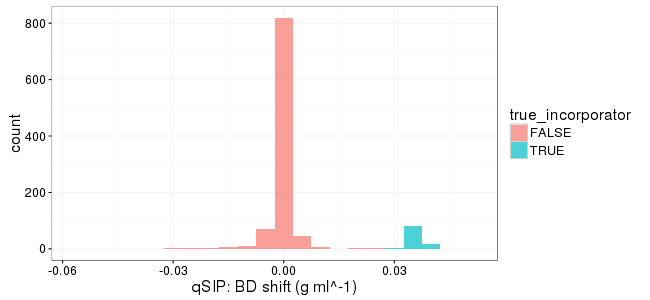

In [36]:
%%R -w 650 -h 300

ggplot(df.j, aes(BD_diff, fill=true_incorporator)) + 
    geom_histogram(binwidth=0.005, alpha=0.7, position='identity') +
    scale_color_discrete('Incorporator?') +
    labs(x='qSIP: BD shift (g ml^-1)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

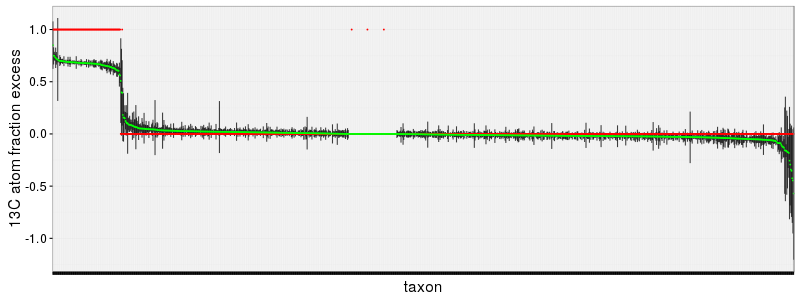

In [37]:
%%R -w 800 -h 300

df.j$taxon = reorder(df.j$taxon, -df.j$atom_fraction_excess)

ggplot(df.j, aes(taxon, true_atom_fraction_excess,
                 ymin=atom_CI_low, ymax=atom_CI_high)) + 
    geom_linerange(alpha=0.75) +
    geom_point(color='red', size=0.25) +
    geom_point(aes(y=atom_fraction_excess), color='green', size=0.2) +
    labs(y='13C atom fraction excess') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

### regression

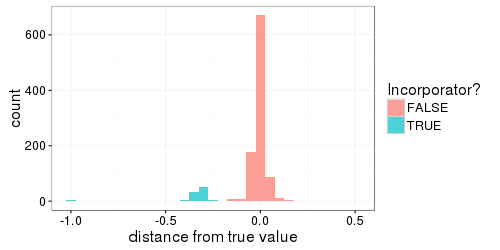

In [52]:
%%R -w 500 -h 250
# true incorporator error

ggplot(df.j, aes(atom_fraction_excess - true_atom_fraction_excess, 
                 fill=true_incorporator)) + 
    geom_histogram(binwidth=0.05, alpha=0.7, position='identity') +
    scale_fill_discrete('Incorporator?') +
    labs(x='distance from true value') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [94]:
%%R
zip.res = pscl::zeroinfl(true_atom_fraction_excess ~ atom_fraction_excess, data=df.j)
zip.res %>% summary %>% print


Call:
pscl::zeroinfl(formula = true_atom_fraction_excess ~ atom_fraction_excess, 
    data = df.j)

Pearson residuals:
     Min       1Q   Median       3Q      Max 
-0.80419 -0.05653 -0.04756 -0.04061 16.04428 

Count model coefficients (poisson with log link):
                     Estimate Std. Error z value Pr(>|z|)
(Intercept)            -1.651      1.149  -1.437    0.151
atom_fraction_excess    2.430      1.705   1.425    0.154

Zero-inflation model coefficients (binomial with logit link):
                     Estimate Std. Error z value Pr(>|z|)   
(Intercept)             4.062      1.236   3.287  0.00101 **
atom_fraction_excess  -16.903      5.243  -3.224  0.00126 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 33 
Log-likelihood: -122.8 on 4 Df


In [96]:
%%R
update(zip.res, . ~ 1) %>% logLik

'log Lik.' -345.2394 (df=2)


In [38]:
%%R
lm.res = lm(true_atom_fraction_excess ~ atom_fraction_excess, data=df.j)
lm.res %>% summary


Call:
lm(formula = true_atom_fraction_excess ~ atom_fraction_excess, 
    data = df.j)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.71953 -0.03111 -0.00489  0.01746  0.97995 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.020047   0.002791   7.182 1.28e-12 ***
atom_fraction_excess 1.378251   0.013280 103.786  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08868 on 1080 degrees of freedom
Multiple R-squared:  0.9089,	Adjusted R-squared:  0.9088 
F-statistic: 1.077e+04 on 1 and 1080 DF,  p-value: < 2.2e-16



## Calculating a confusion matrix

In [105]:
!SIPSimR qSIP_confuseMtx \
    --libs 2,4,6 \
    ampFrags_BD-shift.txt \
    OTU_n2_abs1e9_PCR_subNorm_qSIP_atom.txt

File written: qSIP-cMtx
File written: qSIP-cMtx_data.txt
File written: qSIP-cMtx_table.txt
File written: qSIP-cMtx_overall.txt
File written: qSIP-cMtx_byClass.txt


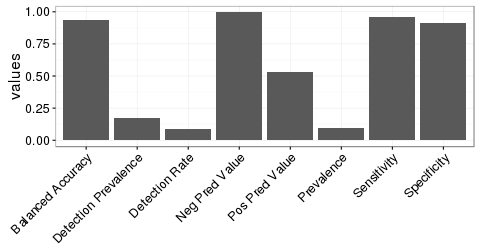

In [106]:
%%R -h 250
df = read.delim('qSIP-cMtx_byClass.txt', sep='\t') %>%
    filter(library == 2)

ggplot(df, aes(variables, values)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

In [107]:
%%R
df

  library            variables     values
1       2          Sensitivity 0.96153846
2       2          Specificity 0.91182365
3       2       Pos Pred Value 0.53191489
4       2       Neg Pred Value 0.99562363
5       2           Prevalence 0.09437387
6       2       Detection Rate 0.09074410
7       2 Detection Prevalence 0.17059891
8       2    Balanced Accuracy 0.93668105


# delta BD 

* delta-BD as calculated in: 

> Pepe-Ranney C, Campbell AN, Koechli C, Berthrong ST, Buckley DH. (2015). Unearthing the microbial ecology of soil carbon cycling with DNA-SIP. bioRxiv 022483.

In [120]:
!SIPSim deltaBD \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    qSIP_exp_design.txt \
    > OTU_n2_abs1e9_PCR_subNorm_dBD.txt  

Loading OTU tables...
Calculating delta BD...


In [25]:
%%R 

df_dBD = read.delim('OTU_n2_abs1e9_PCR_subNorm_dBD.txt', sep='\t')

df_shift = read.delim('ampFrags_BD-shift.txt', sep='\t') %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median)


df_dBD %>% head(n=3) %>% print 
print('------------------------')
df_shift %>% head(n=3) %>% print

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.718719          1.703141
2 Acetobacter_pasteurianus_IFO_3283-03        1.723052          1.713098
3       Acetobacterium_woodii_DSM_1030        1.705494          1.740540
  stdev_CM_control stdev_CM_treatment     delta_BD
1      0.012331730       0.0035449434 -0.015578144
2      0.001636446       0.0007461708 -0.009954024
3      0.003199921       0.0006170283  0.035046087
[1] "------------------------"
Source: local data frame [3 x 2]

                                 taxon median_true_BD_shift
                                (fctr)                (dbl)
1       Acaryochloris_marina_MBIC11017                0.000
2       Acetobacterium_woodii_DSM_1030                0.036
3 Acetobacter_pasteurianus_IFO_3283-03                0.000


In [26]:
%%R
df.j = inner_join(df_dBD, df_shift, c('taxon' = 'taxon')) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.03, TRUE, FALSE))
df.j %>% head(n=3)

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.718719          1.703141
2 Acetobacter_pasteurianus_IFO_3283-03        1.723052          1.713098
3       Acetobacterium_woodii_DSM_1030        1.705494          1.740540
  stdev_CM_control stdev_CM_treatment     delta_BD median_true_BD_shift
1      0.012331730       0.0035449434 -0.015578144                0.000
2      0.001636446       0.0007461708 -0.009954024                0.000
3      0.003199921       0.0006170283  0.035046087                0.036
  true_incorporator
1             FALSE
2             FALSE
3              TRUE


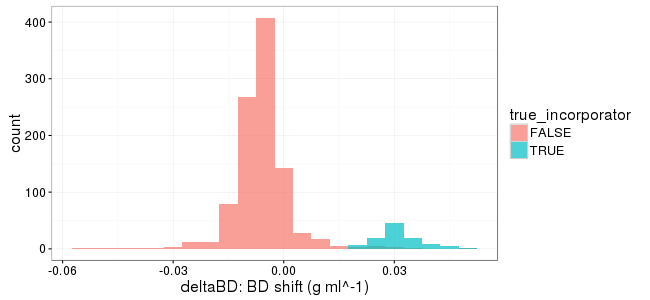

In [27]:
%%R -w 650 -h 300

ggplot(df.j, aes(delta_BD, fill=true_incorporator)) + 
    geom_histogram(binwidth=0.005, alpha=0.7, position='identity') +
    scale_color_discrete('Incorporator?') +
    labs(x='deltaBD: BD shift (g ml^-1)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

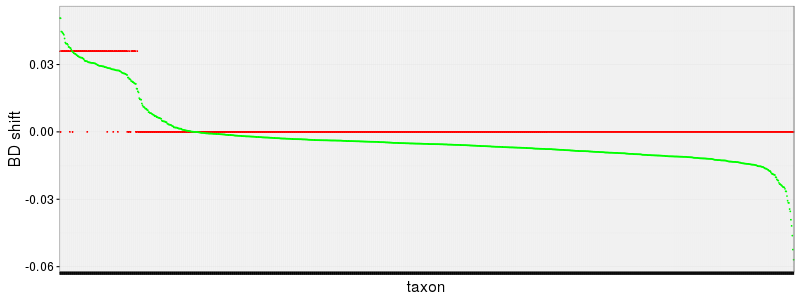

In [28]:
%%R -w 800 -h 300

df.j$taxon = reorder(df.j$taxon, -df.j$delta_BD)

ggplot(df.j, aes(taxon, median_true_BD_shift)) + 
    geom_point(color='red', size=0.25) +
    geom_point(aes(y=delta_BD), color='green', size=0.2) +
    labs(y='BD shift') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

In [31]:
%%R
lm.res = lm(median_true_BD_shift ~ delta_BD, data=df.j)
lm.res %>% summary


Call:
lm(formula = median_true_BD_shift ~ delta_BD, data = df.j)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.037801 -0.002759 -0.000799  0.002043  0.031762 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.005068   0.000187   27.09   <2e-16 ***
delta_BD    0.646953   0.013836   46.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.006095 on 1100 degrees of freedom
Multiple R-squared:  0.6653,	Adjusted R-squared:  0.665 
F-statistic:  2186 on 1 and 1100 DF,  p-value: < 2.2e-16

